### **Qualitative Analysis of Captions**

In [197]:
from evaluation.BLEU import BLEU 
from evaluation.METEOR import METEOR
from evaluation.ROUGE import ROUGE_L
import json
import pandas as pd 
import numpy as np 

from models.transformer import ImageCaptioningTransformer
import torch
from PIL import Image
from dataset.dataset import transform
from embedding.embedding import vocab_npa, stoi

import re

from collections import defaultdict
with open("config.json", "r") as json_file:
    cfg = json.load(json_file)

CHECKPOINT_PATH = cfg['paths']['checkpoint_path']
CAPTIONS_PATH = cfg["paths"]["captions_path"]
IMAGE_PATH = cfg["paths"]["image_path"]

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
pad_idx = stoi('<PAD>')
sos_idx = stoi('<SOS>')
eos_idx = stoi('<EOS>')
unk_idx = stoi('<UNK>')

CAPTIONS_LENGTH = 20
num_captions = 5
temperature = 0.2
max_unk_wait = 30

In [198]:
test_data = pd.read_csv(f"{CAPTIONS_PATH}test.txt", header=None)
test_data.columns = ['image', 'caption']
test_data_unique = test_data.drop_duplicates(subset=['image'])
test_data_unique.columns = ['image', 'caption']

In [199]:
test_data.head()

,image,caption
0,2714703706_d21c5cb8df.jpg,dogs playing
1,2714703706_d21c5cb8df.jpg,A brown dog is biting a white and tan dog on t...
2,2714703706_d21c5cb8df.jpg,The brown dog has a hold of the other dogs che...
3,2714703706_d21c5cb8df.jpg,Two dogs are nuzzling each other nose to nose .
4,2714703706_d21c5cb8df.jpg,Two dogs bite at each other on the carpet .


In [200]:
test_data_unique.head()

,image,caption
0,2714703706_d21c5cb8df.jpg,dogs playing
5,3532194771_07faf20d76.jpg,A man is heading out to see with his surfboard...
10,2356574282_5078f08b58.jpg,A Arabian dressed lady leans backwards holding...
15,3526150930_580908dab6.jpg,A woman and a young girl pose and smile for a ...
20,2448270671_5e0e391a80.jpg,A brown dog is leaping over a fallen tree in t...


In [201]:
image_ids = list(test_data.image)
test_captions = list(test_data.caption)

In [202]:
references = defaultdict(list)
for i in range(0, len(test_captions), 5):
    references[image_ids[i]] = test_captions[i:i+5]

In [203]:
references

defaultdict(list,
            {'2714703706_d21c5cb8df.jpg': ['dogs playing',
              'A brown dog is biting a white and tan dog on the snout .',
              'The brown dog has a hold of the other dogs cheek with its teeth .',
              'Two dogs are nuzzling each other nose to nose .',
              'Two dogs bite at each other on the carpet .'],
             '3532194771_07faf20d76.jpg': ['A man is heading out to see with his surfboard in hand .',
              'A man with a white surfboard is walking into the water .',
              'A person walks into the water carrying a white surfboard .',
              'A surfer walking into the ocean',
              'Surfer with board marches out to sea on gray day .'],
             '2356574282_5078f08b58.jpg': ['A Arabian dressed lady leans backwards holding a skinny crooked sword .',
              'A costumed woman with a sword does a backbend .',
              'A woman bending over backwards .',
              'A woman in a belly d

In [204]:
trained_model = ImageCaptioningTransformer(cap_len=CAPTIONS_LENGTH).to(device)
state_dict = torch.load(
    f'{CHECKPOINT_PATH}transformer_caplen{CAPTIONS_LENGTH}.pth',
    weights_only=True
)['model_state_dict']
trained_model.load_state_dict(state_dict)
trained_model.eval()

C:\Users\Administrator\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\torch\nn\modules\transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


ImageCaptioningTransformer(
  (cnn): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(
          (

In [205]:
def generate_caption_single_img(model, img_jpg, num_captions=1):
    img = transform(
        Image.open(f'{IMAGE_PATH}{img_jpg}').convert('RGB')
    )
    img = torch.unsqueeze(img, 0).to(device)

    candidates = []
    for _ in range(num_captions):
        caption = [[pad_idx for _ in range(CAPTIONS_LENGTH)]]
        caption = torch.tensor(caption).to(device)
        caption[0, 0] = sos_idx
        caption_str = '<SOS> '

        unk_wait = 0
        next_idx = 1
        with torch.no_grad():
            while next_idx < CAPTIONS_LENGTH:
                output_logits = model(img, caption)
                output_logits = output_logits / temperature

                output_probs = torch.softmax(output_logits, dim=-1)
                output = torch.multinomial(output_probs, num_samples=1).item()

                if output == unk_idx:
                    unk_wait += 1
                    if unk_wait < max_unk_wait:
                        continue
                
                unk_wait = 0

                caption_str += f'{vocab_npa[output]} '
                caption[0, next_idx] = output

                if output == eos_idx:
                    break

                next_idx += 1
        caption_str = re.sub(r'[<SOS><EOS>]', '', caption_str)
        caption_str = caption_str.strip()
        candidates.append(caption_str)
    return candidates

In [206]:
def compute_scores_random(model, image_ids, references):
    candidates = []
    cnt = 0
    for img_jpg in image_ids:
        candidates.extend(generate_caption_single_img(model, img_jpg))
        cnt += 1
        if cnt % 100 == 0: 
            print(cnt)
        
    # we will calculate BLEU, METEOR, ROUGE-L here 
    bleu = BLEU(references, candidates)
    meteor = METEOR(references, candidates)
    rouge_l = ROUGE_L(references, candidates)
    d = {'BLEU-1': bleu.bleu1(), 'BLEU-4': bleu.bleu4(), 'METEOR': meteor.meteor(), 'ROUGE-L': rouge_l.rouge_l()}

    return list(d.items()), candidates

In [207]:
import matplotlib.pyplot as plt
from PIL import Image

# Function to display image with captions and metrics
def display_image_with_metrics(image_path, actual_captions, predicted_caption, bleu1_score, bleu4_score, meteor_score, rouge_l_score):
    # Load the image
    img = Image.open(image_path)
    
    # Format actual captions as a multi-line string
    actual_caption_text = "\n".join(f"- {caption}" for caption in actual_captions)
    
    # Create a figure and axis
    fig, ax = plt.subplots(figsize=(8, 8))
    
    # Display the image
    ax.imshow(img)
    ax.axis('off')  # Hide axes
    
    # Add the captions and BLEU score as a title
    caption_text = (
        f"Actual Captions:\n{actual_caption_text}\n\n"
        f"Predicted Caption: {predicted_caption}\n"
        f"BLEU-1 Score: {bleu1_score:.5f}\n"
        f"BLEU-4 Score: {bleu4_score:.5f}\n"
        f"METEOR Score: {meteor_score:.5f}\n"
        f"ROUGE-L Score: {rouge_l_score:.5f}\n"
        
    )
    plt.title(caption_text, fontsize=12, loc='left', wrap=True)
    
    # Show the plot
    plt.show()

### **Good captions**

In [208]:
# test with image  
img_jpg = '2356574282_5078f08b58.jpg'
image_path = f'{IMAGE_PATH}{img_jpg}'

In [209]:
actual_captions = [reference.lower() for reference in references[img_jpg]]

In [210]:
result = compute_scores_random(trained_model, image_ids=[img_jpg], references=[actual_captions])

In [211]:
scores = result[0]
predicted_caption = result[1][0]
scores, predicted_caption

([('BLEU-1', 0.3888888888888889),
  ('BLEU-4', 0.15464260451973763),
  ('METEOR', 0.4148325997065493),
  ('ROUGE-L', 0.2774378548572097)],
 'a woman in a red dress and a woman in a black dress and a black UNK .')

In [212]:
bleu1_score = scores[0][1]
bleu4_score = scores[1][1]
meteor_score = scores[2][1]
rouge_l_score = scores[3][1]

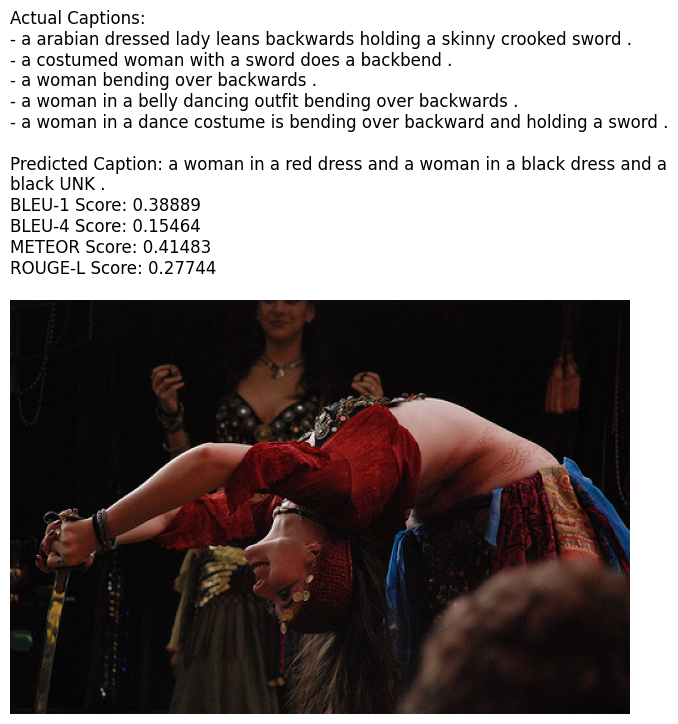

In [213]:
display_image_with_metrics(image_path, actual_captions, predicted_caption, bleu1_score, bleu4_score, meteor_score, rouge_l_score)